In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from datasets import Dataset, ClassLabel, Features

# Fix tokenizer parallelism issue on macOS
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
# --- 1. Load Data and Create Combined Text Feature ---
df = pd.read_parquet('processed_customer_support_data.parquet')

# Combine subject + description into a single feature
df['combined_text'] = df['Ticket Subject'] + " | " + df['Cleaned_Description']

# --- 2. Prepare Data for Hugging Face ---
class_names = sorted(df['Category'].unique().tolist())
label_map = {label: i for i, label in enumerate(class_names)}
df['label'] = df['Category'].map(label_map)

df = df[['combined_text', 'label', 'Category']]  # Keep only needed columns
df = df.rename(columns={'combined_text': 'text'})

print("\nLabel mapping:")
print(label_map)


Label mapping:
{'Account Access': 0, 'Billing': 1, 'General Query': 2, 'Technical Issue': 3}


In [20]:
# --- 3. Tokenizer ---
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# --- 4. Convert to Hugging Face Dataset ---
hg_dataset = Dataset.from_pandas(df, preserve_index=False)

features = Features({
    'text': hg_dataset.features['text'],
    'label': ClassLabel(names=class_names),
    'Category': hg_dataset.features['Category']
})
hg_dataset = hg_dataset.cast(features)

tokenized_datasets = hg_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text", "Category"])
tokenized_datasets.set_format("torch")

Casting the dataset:   0%|          | 0/8469 [00:00<?, ? examples/s]

Map:   0%|          | 0/8469 [00:00<?, ? examples/s]

In [21]:
# --- 5. Train/Val/Test Split ---
split_dataset = tokenized_datasets.train_test_split(test_size=0.2, stratify_by_column="label")
train_dataset = split_dataset["train"]
eval_test_split = split_dataset["test"].train_test_split(test_size=0.5, stratify_by_column="label")
eval_dataset = eval_test_split["train"]
test_dataset = eval_test_split["test"]

print("\nData prepared successfully:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Data prepared successfully:
Training samples: 6775
Validation samples: 847
Test samples: 847


In [22]:
# --- 6. Load Model ---
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(class_names), 
    id2label=id2label, 
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# --- 7. Training Arguments ---
training_args = TrainingArguments(
    output_dir="distilbert-combined-text-classifier",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    dataloader_num_workers=0,   # prevents BrokenPipe on macOS
    report_to=[]                # disable wandb/mlflow
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
# --- 8. Metrics Function ---
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# --- 9. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_27492/1149334058.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
# --- 10. Train ---
print("\nStarting fine-tuning with COMBINED text features...")
trainer.train()
print("\nFine-tuning complete.")

# --- 11. Final Evaluation on Test Set ---
print("\nPerforming final evaluation on the test set...")
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(test_dataset['label'])

# Convert numeric labels back to string labels
y_pred_str = [id2label[i] for i in y_pred]
y_true_str = [id2label[i] for i in y_true]


Starting fine-tuning with COMBINED text features...


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.896103,0.624557,0.483693
2,0.942200,0.894028,0.624557,0.483693


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Fine-tuning complete.

Performing final evaluation on the test set...


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Accuracy: 0.6246

Classification Report:
                 precision    recall  f1-score   support

 Account Access       1.00      1.00      1.00        51
        Billing       0.60      1.00      0.75       478
  General Query       0.00      0.00      0.00       154
Technical Issue       0.00      0.00      0.00       164

       accuracy                           0.62       847
      macro avg       0.40      0.50      0.44       847
   weighted avg       0.40      0.62      0.48       847


Confusion Matrix:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


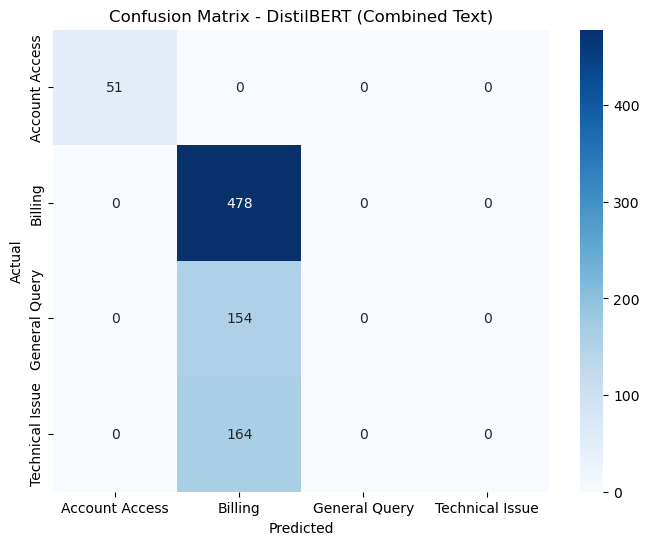

In [26]:
print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true_str, y_pred_str))

# --- 12. Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_str, y_pred_str, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT (Combined Text)')
plt.show()